In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn import model_selection, metrics
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import math
import keras
import glob


import os
print(os.listdir("../input"))

['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


Using TensorFlow backend.


In [2]:
def load_data(train_path='../input/train_V2.csv', test_path='../input/test_V2.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col="Id")
    test = pd.DataFrame.from_csv(test_path, index_col="Id")
    
    return train, test

In [3]:
train, test = load_data()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# train = train[:5000]
# test = test[:2000]

In [5]:
train.dropna(axis=0, inplace=True)

In [6]:
train.winPlacePerc = np.where(train.winPlacePerc >= 0.5 , 1, 0)

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train.drop('winPlacePerc', axis=1), train.winPlacePerc, test_size=0.2, shuffle=None)

In [8]:
def train_classification_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):

    steps_per_period = steps / periods  

    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )

    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=cols,
        n_classes=2,
        optimizer=my_optimizer,
        hidden_units=[64, 128, 64],
        model_dir=m_dir
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        classifier.evaluate(input_fn=validation_input_fn)
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=ptraining_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,2)

        validation_predictions = list(classifier.predict(input_fn=validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,2)    
        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(y_train, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(y_test, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])

    accuracy = metrics.accuracy_score(y_test, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(y_test, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

In [9]:
# matchType = tf.feature_column.categorical_column_with_vocabulary_list(train.matchType, vocabulary_list=['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
# 'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
#        'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
#        'crashtpp', 'normal-solo'])
# cols = [tf.feature_column.numeric_column(i) for i in X_train.columns.values]
cols = [tf.feature_column.numeric_column(i) for i in X_train.select_dtypes(exclude=['object'])]
for i in train.select_dtypes(include=['object']).columns.values:
    cols.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key=i, vocabulary_list=train[i].unique())))
# cols.append(matchType)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/model1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5f6b781748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
LogLoss error (on validation data):
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructi

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 02 : 3.63
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 60 into /tmp/model1/model.ckpt.
INFO:tensorflow:loss = 53.10429, step = 61
INFO:tensorflow:Saving checkpoints for 80 into /tmp/model1/model.ckpt.
INFO:tensorflow:Loss for final step: 56.772552.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-18-17:13:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/

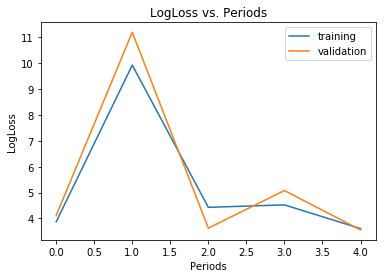

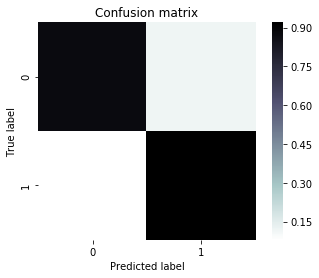

In [10]:
model = train_classification_model(
    learning_rate=0.005,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    periods=5,
    m_dir='/tmp/model1')

In [11]:
scores1 = model.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores1):
    res.append(p['class_ids'][0])   

# result = pd.DataFrame(res, columns=['ImageId', 'Label'])
# result.to_csv('model1.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
submission = pd.DataFrame(
    {"Id": test.index, "winPlacePerc": res},
    columns=["Id", "winPlacePerc"]
)
submission.to_csv("submission.csv", index=False)